In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [2]:
import numpy as np

import utils.windFarms as wfman
from utils.networks import GraphNeuralNet as GNN
from utils.graphNetHelpers import graph2inputs
from utils.testUtils import test_direction, test_speed, test_speed_direction, pprint_graph, test_turbine_numbers
import matplotlib.pyplot as plt
import torch

In [3]:
x_grid_size = 4000
y_grid_size = 4000
base_config_path = '../configs/example_input_JK100.json'
update_config_path = '../configs/update_floris_configs.json'
single_input_path = '../configs/example_input_single.json'
min_distance_factor = 2.0
angle_threshold = 90

wind_farm_man = wfman.RandomSampleManager(x_grid_size=x_grid_size,
                                          y_grid_size=y_grid_size,
                                          update_config_json_path=update_config_path,
                                          base_config_json_path=base_config_path,
                                          single_input_path=single_input_path,
                                          angle_threshold=angle_threshold,
                                          min_distance_factor=min_distance_factor,
                                          dist_cutoff_factor=25)

In [4]:
wind_farm_man.x_coords

In [5]:
pib_path = '../pib_saves/pib8'
dib_path = '../dib_saves/dib3'

pib_load = GNN.load(pib_path, device='cpu')
dib_load = GNN.load(dib_path, device='cpu')
pib_load.eval()
dib_load.eval()

GraphNeuralNet(
  (layers): ModuleList(
    (0): GraphNetworkBlock(
      (encoders): ModuleList(
        (0): MultiLayerPerceptron(
          (layers): ModuleList(
            (0): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): Linear(in_features=8, out_features=256, bias=True)
            (2): Linear(in_features=256, out_features=256, bias=True)
            (3): Linear(in_features=256, out_features=128, bias=True)
            (4): Linear(in_features=128, out_features=50, bias=True)
          )
        )
        (1): MultiLayerPerceptron(
          (layers): ModuleList(
            (0): BatchNorm1d(54, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): Linear(in_features=54, out_features=256, bias=True)
            (2): Linear(in_features=256, out_features=256, bias=True)
            (3): Linear(in_features=256, out_features=128, bias=True)
            (4): Linear(in_features=128, out_features=50, bias=True

In [6]:
use_power = True

In [7]:
wind_speed = np.linspace(8.0, 15.0, 20)
wind_directions = np.linspace(0, 360, 20)
num_turbines = np.arange(5,100).tolist()

In [8]:
# num_turbines = np.arange(5,100).tolist()
# pib_mean, pib_stds = test_turbine_numbers(pib_load, wind_farm_man, num_turbines,
#                                           min_ws=6.0, max_ws=15.0, num_sampling=40)

In [9]:
# dib_mean, dib_stds = test_turbine_numbers(dib_load, wind_farm_man, num_turbines,
#                                           min_ws=6.0, max_ws=15.0, num_sampling=40)

In [10]:
# import pickle

# with open("pib_mean.txt", 'wb') as f:
#     pickle.dump(pib_mean, f)

# with open("pib_stds.txt", 'wb') as f:
#     pickle.dump(pib_stds, f)
    
# with open("dib_mean.txt", 'wb') as f:
#     pickle.dump(dib_mean, f)
    
# with open("dib_stds.txt", 'wb') as f:
#     pickle.dump(dib_stds, f)

In [11]:
import pickle

In [12]:
with open("pib_mean.txt", "rb") as f:
    pib_mean = pickle.load(f)
    
with open("pib_stds.txt", "rb") as f:
    pib_stds = pickle.load(f)

with open("dib_mean.txt", "rb") as f:
    dib_mean = pickle.load(f)
    
with open("dib_stds.txt", "rb") as f:
    dib_stds = pickle.load(f)

In [13]:
# print(np.array(pib_mean) - np.array(load_pib_mean))
# print(np.array(pib_stds) - np.array(load_pib_stds))
# print(np.array(dib_mean) - np.array(load_dib_mean))
# print(np.array(dib_stds) - np.array(load_dib_stds))

In [14]:
pib_upper = np.array(pib_mean) + np.array(pib_stds)
pib_lower = np.array(pib_mean) - np.array(pib_stds)

dib_upper = np.array(dib_mean) + np.array(dib_stds)
dib_lower = np.array(dib_mean) - np.array(dib_stds)

In [40]:
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')

fig, ax = plt.subplots(figsize=(10,5), dpi=300)
ax.fill_between(num_turbines, pib_upper, pib_lower, color='#b3cde0', alpha=0.5, label='+/- 1 std')
pib_pred, = ax.plot(num_turbines, pib_mean, '-', c='#005b96', label='PGNN')

ax.fill_between(num_turbines, dib_upper, dib_lower, color='bisque', alpha=0.3, label='+/- 1 std')
dib_pred, = ax.plot(num_turbines, dib_mean, '-', c='darkorange', label='DGNN')
ax.legend(handles=[pib_pred,dib_pred], loc='upper left')
ax.set_xlabel(r'$n$ (number of wind turbines)',fontsize=15)
ax.set_ylabel(r'$e(n)$',fontsize=15)
#ax.set_title("Generalization errors")
ax.grid()

plt.show()

In [16]:
import os
import json
import glob
import numpy as np
import matplotlib.pyplot as plt

In [17]:
pib_path_base = '../pib_saves/'
pib_paths = sorted(glob.glob(os.path.join(pib_path_base, '*hist*')))

dib_path_base = '../dib_saves/'
dib_paths = sorted(glob.glob(os.path.join(dib_path_base, '*hist*')))

In [18]:
def get_mean_std(file_paths):
    js = []
    for i, path in enumerate(file_paths):
        with open(path) as f:
            j = json.load(f)
            js.append(j)
    
    trains = []
    vals = []

    for j in js:
        trains.append(j['train_loss'])
        vals.append(j['val_loss'])
    
    trains = np.stack(trains)
    vals = np.stack(vals)
    
    mean_trains = np.mean(trains, axis=0)
    std_trains = np.std(trains, axis=0)

    mean_vals = np.mean(vals, axis=0)
    std_vals = np.std(vals, axis=0)
    
    upper_train = mean_trains + std_trains
    lower_train = mean_trains - std_trains

    upper_val = mean_vals + std_vals
    lower_val = mean_vals - std_vals
    
    ret = dict()
    ret['steps'] = j['steps']
    ret['train_mean'] = mean_trains
    ret['train_std'] = std_trains
    ret['train_upper'] = upper_train
    ret['train_lower'] = lower_train
    ret['val_mean'] = mean_vals
    ret['val_std'] = std_vals
    ret['val_upper'] = upper_val
    ret['val_lower'] = lower_val
    ret['trains'] = trains
    ret['vals'] = vals
    return ret

In [19]:
pib_ret = get_mean_std(pib_paths)
dib_ret = get_mean_std(dib_paths)

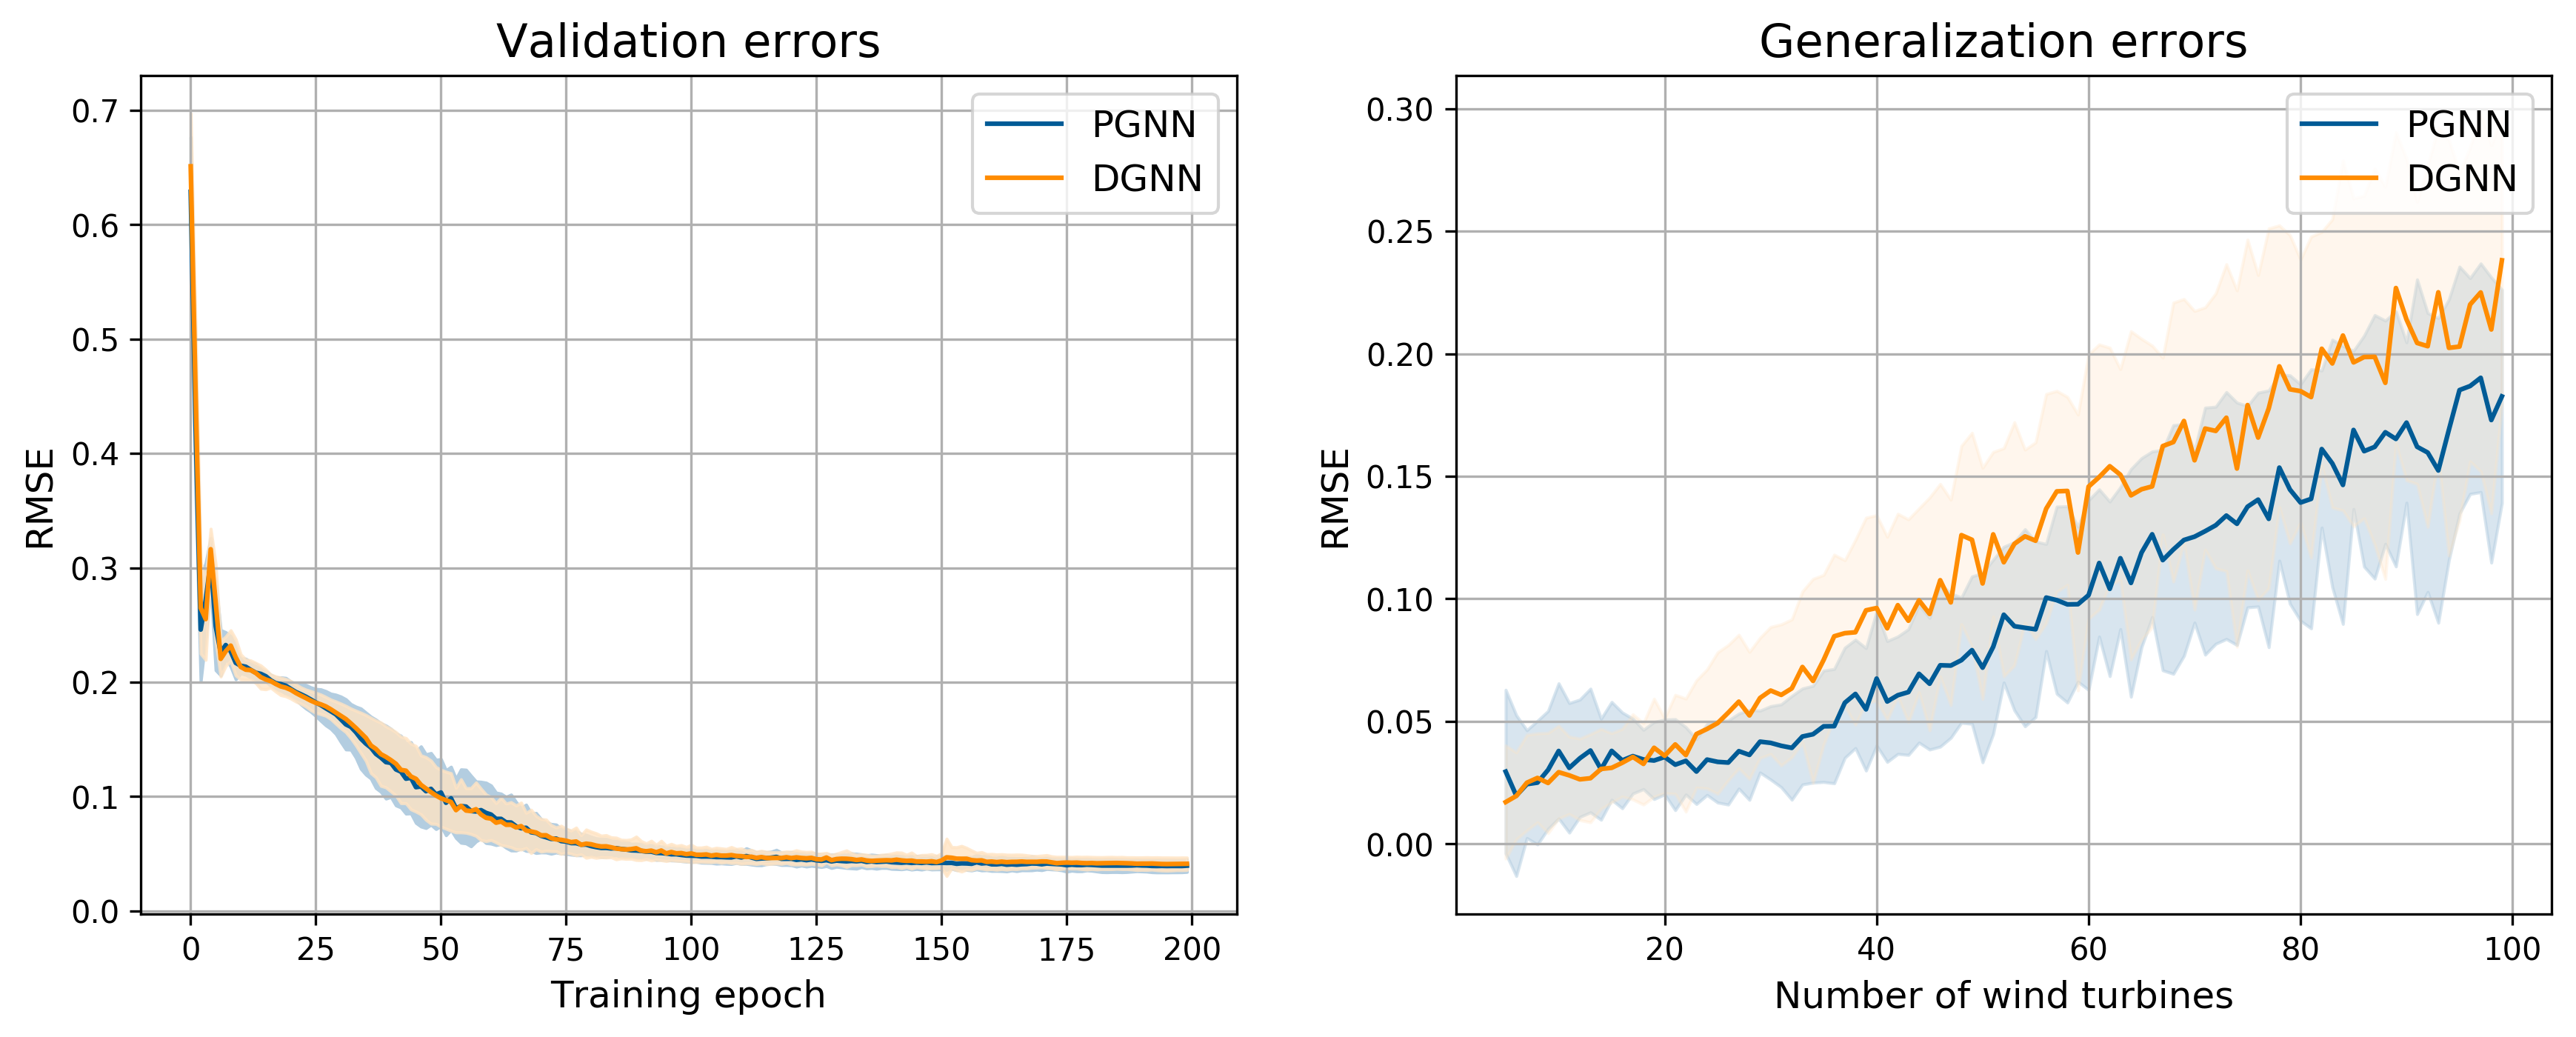

In [20]:
steps = pib_ret['steps']
pib_train_upper = pib_ret['train_upper']
pib_train_lower = pib_ret['train_lower']
pib_train_mean = pib_ret['train_mean']
pib_val_upper = pib_ret['val_upper']
pib_val_lower = pib_ret['val_lower']
pib_val_mean = pib_ret['val_mean']

dib_train_upper = dib_ret['train_upper']
dib_train_lower = dib_ret['train_lower']
dib_train_mean = dib_ret['train_mean']
dib_val_upper = dib_ret['val_upper']
dib_val_lower = dib_ret['val_lower']
dib_val_mean = dib_ret['val_mean']

label_size = 12
title_size = 15


fig, axes = plt.subplots(1,2, figsize=(14,5), dpi=300)

axes[0].fill_between(steps, pib_val_upper, pib_val_lower, color='#b3cde0', alpha=1.0, label='+/- 1 std')
pib_val, = axes[0].plot(steps, pib_val_mean, '-', c='#005b96', label='PGNN')

axes[0].fill_between(steps, dib_val_upper, dib_val_lower, color='bisque', alpha=0.8, label='+/- 1 std')
dib_val, = axes[0].plot(steps, dib_val_mean, '-', c='darkorange', label='DGNN')


axes[0].legend(handles=[pib_val, dib_val], loc='upper right', fontsize=label_size)
axes[0].set_xlabel("Training epoch", fontsize=label_size)
axes[0].set_ylabel("RMSE", fontsize=label_size)
axes[0].set_title("Validation errors", fontsize=title_size)
axes[0].grid()

axes[1].fill_between(num_turbines, pib_upper, pib_lower, color='#b3cde0', alpha=0.5, label='+/- 1 std')
pib_pred, = axes[1].plot(num_turbines, pib_mean, '-', c='#005b96', label='PGNN')

axes[1].fill_between(num_turbines, dib_upper, dib_lower, color='bisque', alpha=0.3, label='+/- 1 std')
dib_pred, = axes[1].plot(num_turbines, dib_mean, '-', c='darkorange', label='DGNN')
axes[1].legend(handles=[pib_pred,dib_pred], loc='upper right', fontsize=label_size)
axes[1].set_xlabel("Number of wind turbines", fontsize=label_size)
axes[1].set_ylabel("RMSE", fontsize=label_size)
axes[1].set_title("Generalization errors", fontsize=title_size)
axes[1].grid()

plt.show()

In [41]:
delta = np.array(dib_mean) - np.array(pib_mean)

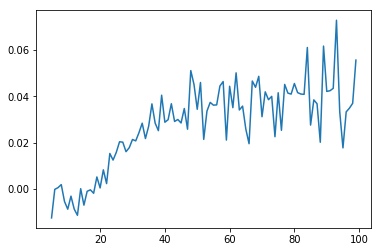

In [42]:
plt.plot(num_turbines,delta)

In [43]:
np.mean(delta[20:])

0.03518993

In [45]:
abs(np.mean(delta[:20]))

0.00063659006